# Prework

In [59]:
import sys
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
import statsmodels.api as sm
from math import sqrt as math_sqrt
from sklearn.metrics import mean_squared_error
import pickle
import math
import random

#Import custom modules
sys.path.append('../')
from utils.utils import *

In [60]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.4.1
Eager execution: True


## Load data

In [61]:
training_data, testing_data, testing_index = load_data()

In [62]:
countries, no_features, feature_names, years, months, weekdays, hours = load_data_information()

In [63]:
# Extracts features, year, etc. from whole data
def change_format(input_data):
    #Extract year from data matrix
    year_w = input_data[:,:,0:1]
    #Extract weekday from data matrix
    weekday_w = input_data[:,:,1:2]
    #Extract hour from data matrix
    hour_w = input_data[:,:,2:3]
    #Extract country from data matrix
    country_w = input_data[:,0:1,3]   
    #Extract month from data matrix
    month_w = input_data[:,:,4:5]
    #Extract features from matrix
    features_w = input_data[:,:,5:5+no_features]
    #Extract matrix of missing values from data matrix
    miss_vals_w = input_data[:,:,-no_features-6:-6]
    #Extract pos enc from data matrix
    pos_enc_w = input_data[:,:,-6:]


    #Prepare format for features
    features_tf = np.reshape(features_w, [features_w.shape[0], -1, 1])
    miss_vals_tf = np.reshape(miss_vals_w, [features_w.shape[0], -1, 1])
    pos_enc_tf = np.reshape(tf.transpose(np.repeat(np.reshape(pos_enc_w, [pos_enc_w.shape[0], pos_enc_w.shape[1], pos_enc_w.shape[2], 1]),
                                                   no_features, axis = 3), perm=[0,1,3,2]),[pos_enc_w.shape[0],-1,pos_enc_w.shape[2]])
    feature_nr_tf = np.repeat(np.reshape(np.repeat(np.reshape(np.array(range(no_features)),[1,-1]), input_data.shape[1], axis = 0),[1,-1]), input_data.shape[0], axis = 0)
    
    #Reshape other features
    hour_tf = np.reshape(np.repeat(hour_w, no_features,axis=2),[input_data.shape[0],-1])
    year_tf = np.reshape(np.repeat(year_w, no_features,axis=2),[input_data.shape[0],-1])
    weekday_tf = np.reshape(np.repeat(weekday_w, no_features,axis=2),[input_data.shape[0],-1])
    month_tf = np.reshape(np.repeat(month_w, no_features,axis=2),[input_data.shape[0],-1])
    
    

    return features_tf, miss_vals_tf, pos_enc_tf, country_w, year_tf, weekday_tf, hour_tf, feature_nr_tf

In [64]:
#Function for testing mask
def get_testing_mask(features, miss_vals, mask):
    mask = mask.reshape(features.shape)
    features_masked = np.array(features)
    features_masked[mask==1] = 0

    miss_vals_masked = np.array(miss_vals)
    miss_vals_masked[mask==1] = 1

    
    return features_masked, miss_vals_masked, mask

# Load predictions over several masks

In [65]:
models = ["transformer","lstm", "locf"]#,"locf","knn"]
results = pd.DataFrame(columns=models)
perc = [0.2,0.4,0.6,0.8]

for p in perc:
    #Load testing mask
    testing_mask = np.load("../evaluation/testing_mask_{}.npy".format(p))

    #Obtain true values
    features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
    features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask)
    true_values = features[mask==1]

    #Load model predictions
    for model in models:
        prediction = np.load("../predictions/{}_pred_{}.npy".format(model,p))

        #Calculate mse
        mse = np.round(mean_squared_error(true_values,prediction),6)

        #Save mse to results
        results.loc[p,model]=mse



In [66]:
results

,transformer,lstm,locf
0.2,0.005985,0.006663,0.113347
0.4,0.008021,0.009532,0.115909
0.6,0.010592,0.013002,0.114991
0.8,0.019094,0.021377,0.114901


<AxesSubplot:>

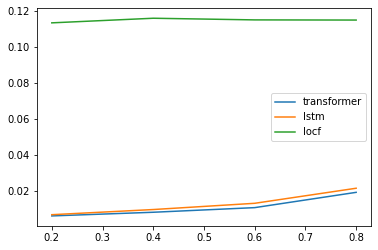

In [67]:
results.plot()

# Create evaluation scheme
Obtain a matrix with true values and information about each prediction in order to make full evaluation

In [68]:
p=0.6
testing_mask = np.load("../evaluation/testing_mask_{}.npy".format(p))
#testing_mask = np.load("../evaluation/testing_mask_test.npy")

In [69]:
#Zieht die Informationen aus dem Testdatensatz
features, miss_vals, pos_enc, country, year, weekday, hour, feature_nr = change_format(testing_data)
features_masked, miss_vals_masked, mask = get_testing_mask(features, miss_vals, testing_mask)
length = 120

#Informationen über true values
true_values_inf = features[mask==1]

#Informationen über die Reihenfolge der Features
feature_number_inf = feature_nr.reshape(feature_nr.shape[0],feature_nr.shape[1],1)[mask==1]

#Informationen über die Länder
country_inf = np.repeat(country,no_features*length,axis=1).reshape(country.shape[0],no_features*length,1)[mask==1]

#Informationen über die Zeitreihe
time_index_reshaped = np.repeat(testing_index.reshape(testing_index.shape[0],testing_index.shape[1],1),no_features,axis=2)
time_index_inf = time_index_reshaped.reshape(testing_index.shape[0],no_features*length,1)[mask==1]

#Informationen über die Sample (Tages-) nummer
sample_inf = np.repeat(np.arange(testing_data.shape[0]).reshape(testing_data.shape[0],1),no_features*length,axis=1).reshape(testing_data.shape[0],no_features*length,1)[mask==1]

In [70]:
# Informationen in einem Dataframe sammeln
information_concat = np.concatenate((time_index_inf, sample_inf, country_inf,feature_number_inf, true_values_inf),axis=0).reshape(-1,true_values_inf.shape[0])
results = pd.DataFrame(information_concat[1:].transpose(), index = information_concat[0], columns = [
    "Sample","Country", "Feature", "True value"])
results["Country"]=results["Country"].astype("int")

# Development: Model evaluation

## Load predictions

In [71]:
transformer_pred = np.load("../predictions/transformer_pred_{}.npy".format(p))
lstm_pred = np.load("../predictions/lstm_pred_{}.npy".format(p))
locf_pred = np.load("../predictions/locf_pred_{}.npy".format(p))
#knn_pred = np.load("../predictions/knn_pred_{}.npy".format(p))

#Add to results dataframe
results["Transformer_pred"]=transformer_pred
results["LSTM_pred"]=lstm_pred
results["LOCF_pred"]=locf_pred
#results["KNN_pred"]=knn_pred

In [72]:
mse_t=mean_squared_error(results["True value"],results["Transformer_pred"])
mse_lstm = mean_squared_error(results["True value"],results["LSTM_pred"])
mse_locf = mean_squared_error(results["True value"],results["LOCF_pred"])
#mse_knn = mean_squared_error(results["True value"],results["KNN_pred"])
mse_res = pd.DataFrame(columns = ["Transformer","LSTM","LOCF"])#,"LOCF","KNN"])
mse_res.loc["MSE"]=[mse_t,mse_lstm,mse_locf]#,mse_locf,mse_knn]
mse_res

,Transformer,LSTM,LOCF
MSE,0.010592,0.013002,0.114991


## Evaluate Models per Feature

In [73]:
methods = results.columns[4:].to_list()
mse_per_feature = pd.DataFrame(columns=methods,index=np.arange(no_features)) 

for feature in np.arange(no_features):
    data_sampled = results[results["Feature"]==feature]

    errors_per_feature = []
    for method in methods:
        mse = mean_squared_error(data_sampled["True value"],data_sampled[method])
        errors_per_feature.append(mse)
    mse_per_feature.loc[feature,:]=errors_per_feature

mse_per_feature.insert(0,"Feature",feature_names)

In [74]:
total = list(["Total"])
total.extend(list(mse_per_feature.mean().values))
mse_per_feature.loc[no_features+1,:]=total

C:\Users\chris\AppData\Local\Temp/ipykernel_13684/3456626454.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  total.extend(list(mse_per_feature.mean().values))


In [75]:
mse_per_feature

,Feature,Transformer_pred,LSTM_pred,LOCF_pred
0,Day_ahead_price,0.042015,0.051323,0.159448
1,Load,0.002948,0.005556,0.020973
2,Biomass,0.002154,0.00325,0.0102
3,Fossil Gas,0.008886,0.010248,0.119717
4,Fossil Oil,0.00034,0.001589,0.001641
5,Other,0.001439,0.002353,0.005061
6,Solar,0.01375,0.020062,0.088383
7,Waste,0.002875,0.004763,0.025297
8,Wind Onshore,0.011724,0.01229,0.40895
9,Wind Offshore,0.026467,0.027996,0.445153


## Evaluate Models per Country 

In [76]:
country_dict = {'AT': 0,
 'BE': 1,
 'BG': 2,
 'CH': 3,
 'CZ': 4,
 'DE-AT-LU': 5,
 'DE-LU': 6,
 'DK': 7,
 'EE': 8,
 'ES': 9,
 'FI': 10,
 'FR': 11,
 'GB': 12,
 'GR': 13,
 'HR': 14,
 'HU': 15,
 'IE': 16,
 'IT': 17,
 'LT': 18,
 'LV': 19,
 'NL': 20,
 'NO': 21,
 'PL': 22,
 'PT': 23,
 'RO': 24,
 'RS': 25,
 'SE': 26,
 'SI': 27,
 'SK': 28}
country_list = list(country_dict.keys())

In [77]:
methods = results.columns[4:].to_list()
mse_per_country = pd.DataFrame(columns=methods,index=countries) 

for country in countries:
    data_sampled = results[results["Country"]==country]

    errors_per_country = []
    for method in methods:
        mse = mean_squared_error(data_sampled["True value"],data_sampled[method])
        errors_per_country.append(mse)
    mse_per_country.loc[country,:]=errors_per_country
    
mse_per_country.insert(0,"Country",country_list)

total=list(["Total"])
total.extend(list(mse_per_country.mean().values))
mse_per_country.loc["Total",:]=total

C:\Users\chris\AppData\Local\Temp/ipykernel_13684/2113119002.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  total.extend(list(mse_per_country.mean().values))


In [78]:
mse_per_country

,Country,Transformer_pred,LSTM_pred,LOCF_pred
0,AT,0.003147,0.003984,0.019569
1,BE,0.004355,0.006043,0.059986
2,BG,0.008506,0.009838,0.039472
3,CH,0.003379,0.004776,0.014415
4,CZ,0.001445,0.001968,0.008524
5,DE-AT-LU,0.069316,0.079669,1.335616
6,DE-LU,0.080275,0.096913,1.564855
7,DK,0.003835,0.004333,0.045329
8,EE,0.002211,0.00328,0.008592
9,ES,0.009461,0.013321,0.135855


# Plot results

## Plot random sample

In [92]:
import matplotlib.dates as mdates

def get_sample_plot(data=results):
    sample = np.random.choice(data["Sample"].unique())
    data_plot = data[data["Sample"]==sample]
    features = data_plot["Feature"].unique()

    fig, axs = plt.subplots(1,5,figsize=(30,8))
    axs = axs.ravel()
    z=-1
    features = np.random.choice(np.arange(no_features),5)
    for feature in features:
        z+=1
        feature_name = feature_names[feature]
        data = data_plot[data_plot["Feature"]==feature]
        axs[z].plot(data.iloc[:,3:],'--o')
        axs[z].legend(data.iloc[:,3:].columns)
        axs[z].set_title("Country : {}, Feature: {}".format(data_plot["Country"][0],feature_name))
        axs[z].xaxis.set_major_formatter(mdates.DateFormatter("%H"))

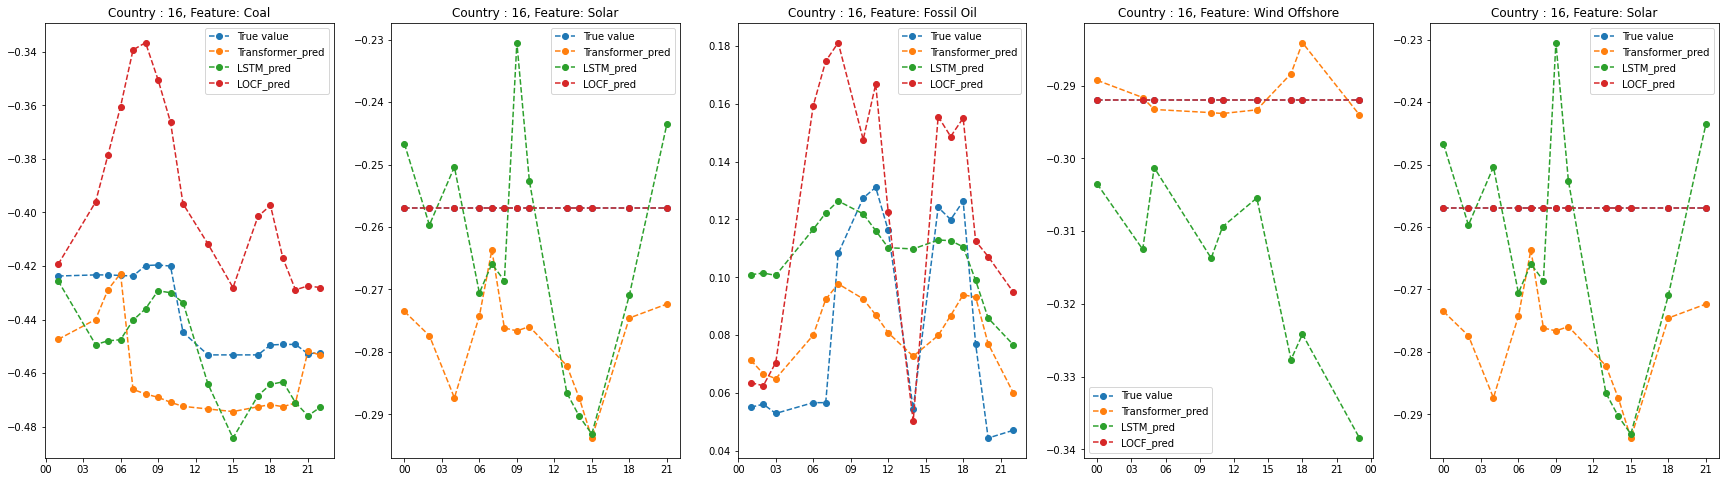

In [93]:
get_sample_plot()

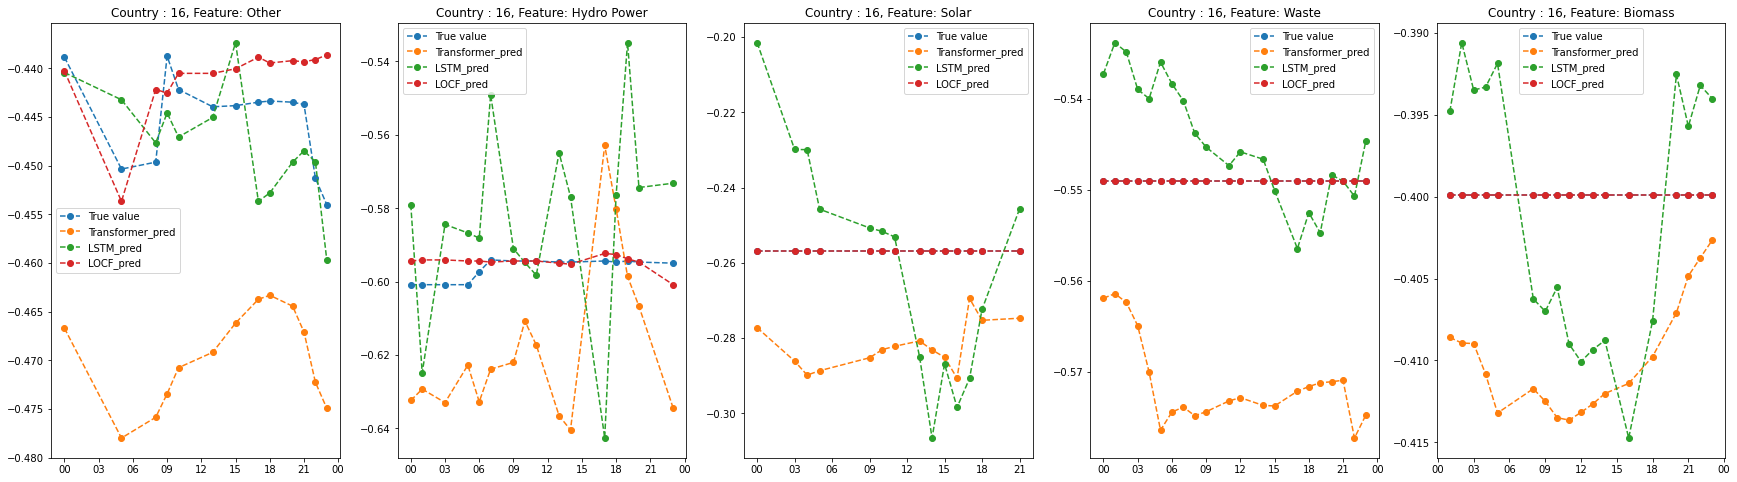

In [94]:
get_sample_plot()

## Plot samples per feature

In [95]:
def plot_samples_per_feature(feature,results=results):

    feature_name=feature_names[feature]
    data_plot=results[results["Feature"]==feature]
    samples = np.random.choice(data_plot["Sample"].unique(),5)

    fig, axs = plt.subplots(1,5,figsize=(25,5))
    z=-1
    for sample in samples:
        z+=1
        data = data_plot[data_plot["Sample"]==sample]
        axs[z].plot(data.iloc[:,3:],'--o')
        axs[z].legend(data.iloc[:,3:].columns)
        axs[z].set_title("Country : {}, Feature: {}".format(data["Country"][0],feature_name))
        axs[z].xaxis.set_major_formatter(mdates.DateFormatter("%H"))

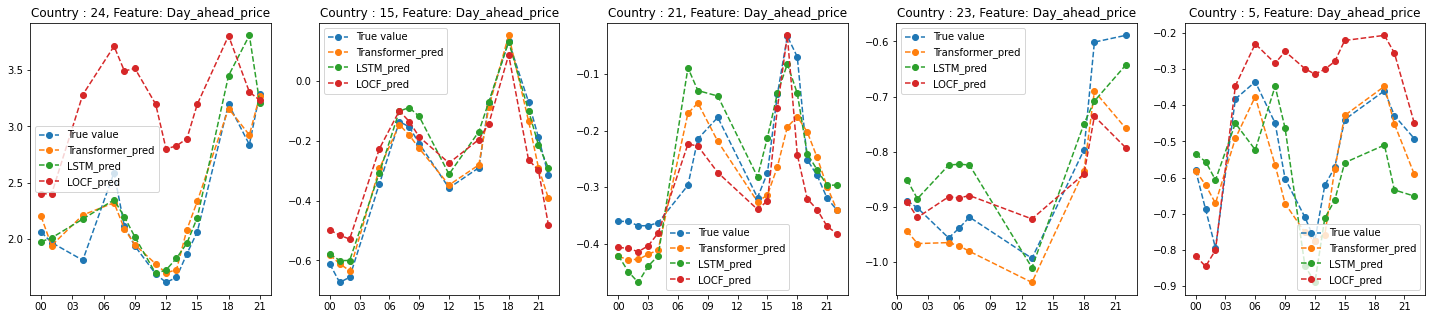

In [96]:
plot_samples_per_feature(0)

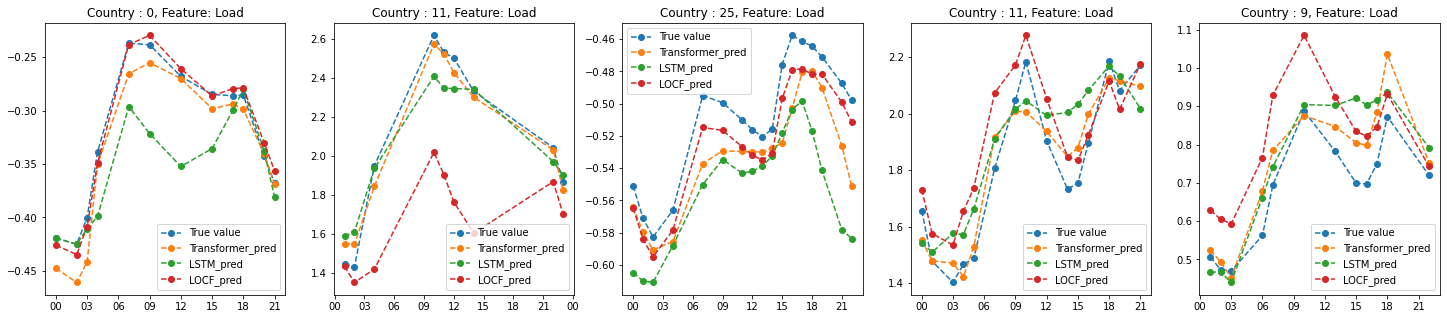

In [97]:
plot_samples_per_feature(1)

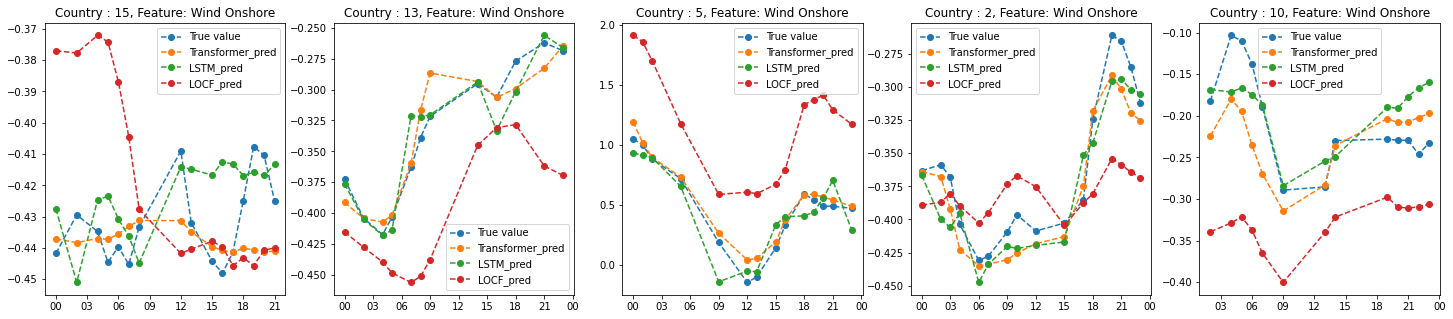

In [98]:
plot_samples_per_feature(8)

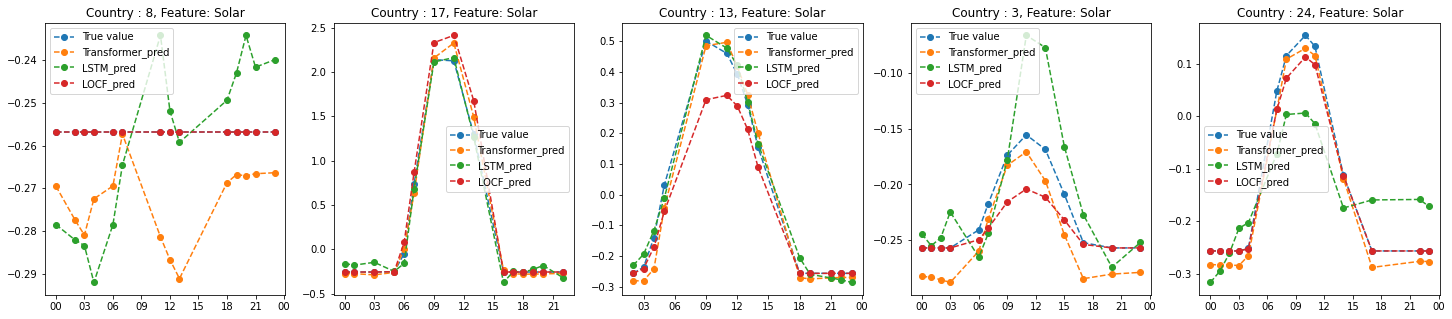

In [99]:
plot_samples_per_feature(6)

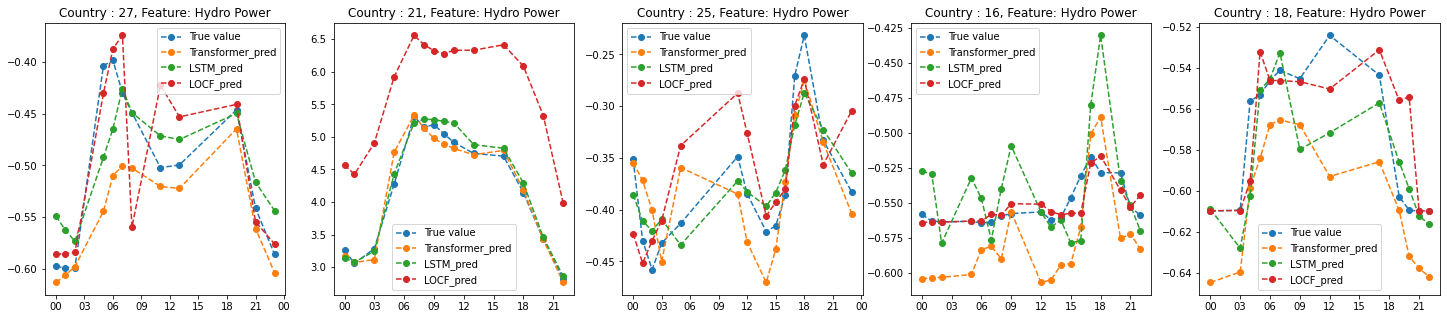

In [100]:
plot_samples_per_feature(10)

# Green house gas emissions

## Keys

Emissions in kg CO2 eq /MWh (2015)

Metal Depletion in kg FE eq/MWh (2015)

In [4]:
ghg_emissions = {
    "Nuclear" : 11.7,
    "Hard Coal" : 1227.3,
    "Lignite" : 1229.0,
    "Fossil Gas" : 488.4,
    "Hydro" : 4.6,
    "Pump Storage" : 56.8,
    "Biomass" : 201.4,
    "PV" : 85.8,
    "Wind" : 27.1
}

metal_depletion = {
    "Nuclear" : 4.1,
    "Hard Coal" : 2.0,
    "Lignite" : 2.3,
    "Fossil Gas" : 3.2,
    "Hydro" : 1.7,
    "Pump Storage" : 4.7,
    "Biomass" : 5.2,
    "PV" : 24.6,
    "Wind" : 23.5
}